In [1]:
!pip install seaborn

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/creditcardfraud


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installedpython
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import precision_recall_curve,average_precision_score,roc_auc_score,classification_report,confusion_matrix
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
files=[]
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        files.append(os.path.join(dirname, filename))
        print(os.path.join(dirname, filename))

/kaggle/input/creditcardfraud/creditcard.csv
/kaggle/input/credit-card-fraud-detection-dataset-2023/creditcard_2023.csv


In [4]:
# read data
df=pd.read_csv(files[0])
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.175161e-15,3.369007e-16,-1.379537e-15,2.094852e-15,1.021879e-15,1.500885e-15,-5.620335e-16,1.149614e-16,-2.426963e-15,...,1.596686e-16,-3.576577e-16,2.650499e-16,4.472317e-15,5.109395e-16,1.686100e-15,-3.662399e-16,-1.225457e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [5]:
# select input, x and true value, y
features=[col for col in df.columns if col not in ('Time','Class')]
x=df[features].copy()
y=df['Class'] # 0: normal , 1: fraud

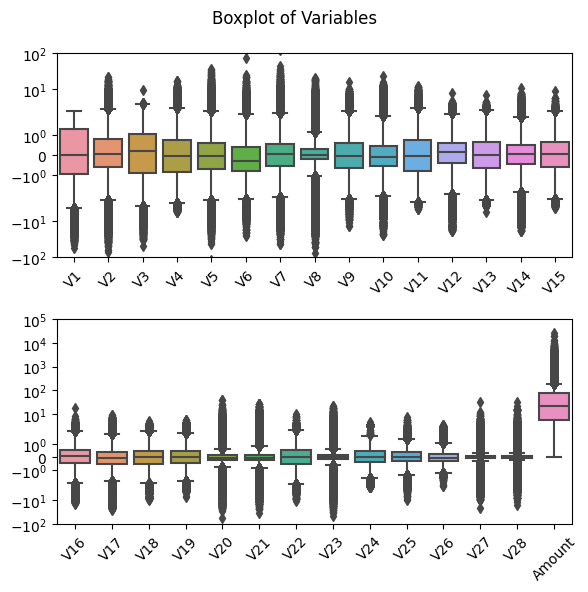

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

fig,ax=plt.subplots(ncols=1,nrows=2,figsize=(6,6))
plt.suptitle('Boxplot of Variables')
sns.boxplot(data=df[features[:15]],ax=ax[0])
sns.boxplot(data=df[features[15:]],ax=ax[1])
ax[0].set_yscale('symlog')
ax[1].set_yscale('symlog')
ax[0].set_ylim(-100,100)
ax[1].set_ylim(-100,1e5)
ax[0].tick_params('x',labelrotation=45)
ax[1].tick_params('x',labelrotation=45)
plt.tight_layout()
plt.savefig('variables_boxplot.jpg',dpi=150)


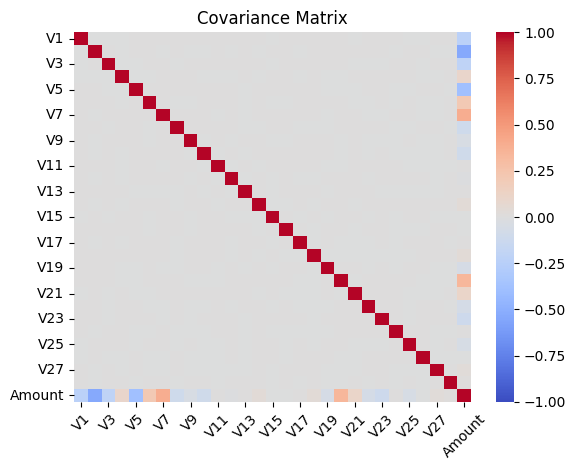

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

x_mean=x.mean()
x_std=x.std()
z=(x-x_mean)/x_std
c=z.cov()
sns.heatmap(c,cmap='coolwarm',vmax=1,vmin=-1)
plt.title('Covariance Matrix')
plt.xticks(rotation=45)
plt.savefig('covariance_matrix.jpg',dpi=150)

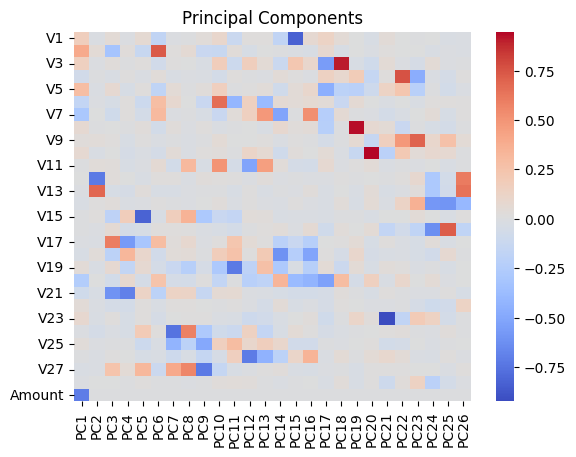

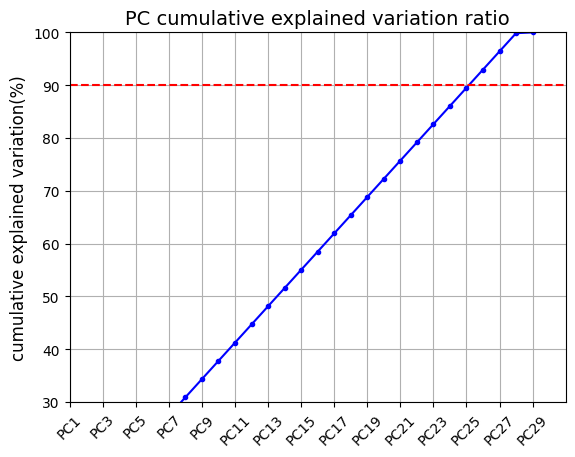

In [8]:
# PCA
explained_critical=0.9

eigenvalues,eigenvectors=np.linalg.eig(c)
idx=eigenvalues.argsort()[::-1]
eigenvalues=eigenvalues[idx]
eigenvectors=eigenvectors[:,idx]
explained_var_ratio=eigenvalues/np.sum(eigenvalues)
explained_var=np.cumsum(eigenvalues)/np.sum(eigenvalues)
n_components=np.argmax(explained_var>=explained_critical)+1
u=eigenvectors[:,:n_components]
pca_idx = np.array([f'PC{i+1}' for i in range(n_components)])
pca_component=pd.DataFrame(u,index=features,columns=pca_idx)

# project to new basis
z_projected=z@pca_component
z_restructured=z_projected@u.T
x_restructured=z_restructured*x_std+x_mean

sns.heatmap(pca_component,cmap='coolwarm')
plt.title('Principal Components')
plt.savefig('PC.jpg',dpi=150)
plt.show()
plt.clf()

plt.plot(np.array(explained_var*100),'.b-')
plt.ylabel('cumulative explained variation(%)',fontsize=12)
plt.title('PC cumulative explained variation ratio',fontsize=14)
plt.hlines(y=explained_critical*100,xmin=0,xmax=30,color='r',linestyle='dashed')
plt.xticks(np.arange(0,30,2),[f'PC{i+1}'for i in range(0,30,2)],rotation=45)
plt.xlim(0,30)
plt.ylim(30,100)
plt.grid()
plt.savefig('pc_explained.jpg',dpi=150)
plt.show()

### Below code are generated by Chat GPT
#### [對話紀錄](https://chatgpt.com/share/68fe319b-8ee8-800c-b392-ec45dcdeb70f)

In [9]:
# split data
RANDOM_SEED=42

scaler=StandardScaler()
x['Amount']=scaler.fit_transform(x[['Amount']])

# from sklearn.preprocessing import RobustScaler
# scaler = RobustScaler()
# x_scaled = scaler.fit_transform(x)

x=x.values
y=y.values

x_normal=x[y==0]
x_fraud=x[y==1]

x_normal_train,x_normal_other=train_test_split(x_normal,test_size=0.3,random_state=RANDOM_SEED)
x_normal_valid, x_normal_test = train_test_split(x_normal_other,test_size=0.5,random_state=RANDOM_SEED)
x_fraud_valid = x_fraud[:len(x_fraud)//2]
x_fraud_test  = x_fraud[len(x_fraud)//2:]

# validation
x_valid = np.vstack([x_normal_valid, x_fraud_valid])
y_valid = np.hstack([np.zeros(len(x_normal_valid)), np.ones(len(x_fraud_valid))])

# 測試集 = 正常 + 另一半詐騙
x_test = np.vstack([x_normal_test, x_fraud_test])
y_test = np.hstack([np.zeros(len(x_normal_test)), np.ones(len(x_fraud_test))])

x_normal_test=x_normal_train[:len(x_normal_train)//2]

In [10]:
# Pytorch dataset
BATCH_SIZE=64

train_dataset=TensorDataset(torch.from_numpy(x_normal_train.astype(np.float32)))
train_loader=DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)

valid_dataset=TensorDataset(torch.from_numpy(x_valid.astype(np.float32)),torch.from_numpy(y_valid.astype(np.int64)))
valid_loader=DataLoader(valid_dataset,batch_size=BATCH_SIZE,shuffle=False)

In [11]:
# autoencoder
class AutoEncoder(nn.Module):
    def __init__(self,input_dim,hidden_dim=16):
        super().__init__()
        # encoder
        self.encoder=nn.Sequential(
            nn.Linear(input_dim,256),
            # nn.BatchNorm1d(64),
            nn.ReLU(),
            # nn.Dropout(0.2),
            nn.Linear(256,hidden_dim),
            nn.ReLU()
        )

        # decoder
        self.decoder=nn.Sequential(
            nn.Linear(hidden_dim,256),
            # nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(256,input_dim),
            # nn.Sigmoid()
        )
    def forward(self,x):
        z=self.encoder(x)
        x_rec=self.decoder(z)
        return x_rec

In [12]:
# create model
HIDDEN_DIM=64
input_dim=x.shape[1]
model=AutoEncoder(input_dim,hidden_dim=HIDDEN_DIM)
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Running on',device)
model=model.to(device)

optimizer=torch.optim.Adam(model.parameters(),lr=1e-3,weight_decay=1e-5)
criterion=nn.MSELoss(reduction='none')

Running on cuda


In [13]:
# train

MODEL_SAVEPATH = "ae_fraud.pth"
EPOCH=15

best_val_loss = np.inf
avg_train_losses = []
avg_val_losses = []

for epoch in range(EPOCH):
    model.train()
    train_losses = []

    # ---- Training loop ----
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCH}"):
        x_batch=batch[0].to(device)
        
        optimizer.zero_grad()
        pred = model(x_batch)
        loss = criterion(pred,x_batch).mean()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    # ---- Validation loop ----
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in valid_loader:
            x_batch = batch[0].to(device) if isinstance(batch, (tuple, list)) else batch.to(device)
            x_noisy = x_batch + 0.01*torch.randn_like(x_batch)
            x_rec = model(x_noisy)
            loss = criterion(x_rec, x_batch).mean()
            val_losses.append(loss.item())

    # ---- Epoch summary ----
    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)
    avg_train_losses.append(train_loss)
    avg_val_losses.append(val_loss)

    # 儲存目前最佳模型
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), MODEL_SAVEPATH)
        print(f"Best model saved (epoch {epoch+1}, val_loss={val_loss:.6f})")

    # 每隔幾輪輸出一次結果
    # if (epoch + 1) % 5 == 0 or epoch == 0:
    print(f"Epoch [{epoch+1}/{EPOCH}] | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")


Epoch 1/15: 100%|██████████| 3110/3110 [00:06<00:00, 483.99it/s]


Best model saved (epoch 1, val_loss=0.014633)
Epoch [1/15] | Train Loss: 0.037277 | Val Loss: 0.014633


Epoch 2/15: 100%|██████████| 3110/3110 [00:05<00:00, 534.98it/s]


Epoch [2/15] | Train Loss: 0.011722 | Val Loss: 0.021619


Epoch 3/15: 100%|██████████| 3110/3110 [00:05<00:00, 531.81it/s]


Epoch [3/15] | Train Loss: 0.009148 | Val Loss: 0.021004


Epoch 4/15: 100%|██████████| 3110/3110 [00:05<00:00, 530.83it/s]


Epoch [4/15] | Train Loss: 0.008224 | Val Loss: 0.020631


Epoch 5/15: 100%|██████████| 3110/3110 [00:05<00:00, 536.61it/s]


Epoch [5/15] | Train Loss: 0.009322 | Val Loss: 0.027508


Epoch 6/15: 100%|██████████| 3110/3110 [00:05<00:00, 534.35it/s]


Best model saved (epoch 6, val_loss=0.006697)
Epoch [6/15] | Train Loss: 0.005983 | Val Loss: 0.006697


Epoch 7/15: 100%|██████████| 3110/3110 [00:05<00:00, 532.13it/s]


Epoch [7/15] | Train Loss: 0.006379 | Val Loss: 0.012690


Epoch 8/15: 100%|██████████| 3110/3110 [00:05<00:00, 535.25it/s]


Epoch [8/15] | Train Loss: 0.005140 | Val Loss: 0.049471


Epoch 9/15: 100%|██████████| 3110/3110 [00:05<00:00, 530.98it/s]


Epoch [9/15] | Train Loss: 0.003670 | Val Loss: 0.012036


Epoch 10/15: 100%|██████████| 3110/3110 [00:05<00:00, 528.35it/s]


Epoch [10/15] | Train Loss: 0.004905 | Val Loss: 0.011253


Epoch 11/15: 100%|██████████| 3110/3110 [00:05<00:00, 534.57it/s]


Epoch [11/15] | Train Loss: 0.003949 | Val Loss: 0.007519


Epoch 12/15: 100%|██████████| 3110/3110 [00:05<00:00, 524.10it/s]


Epoch [12/15] | Train Loss: 0.003993 | Val Loss: 0.016211


Epoch 13/15: 100%|██████████| 3110/3110 [00:05<00:00, 531.65it/s]


Epoch [13/15] | Train Loss: 0.003013 | Val Loss: 0.012989


Epoch 14/15: 100%|██████████| 3110/3110 [00:05<00:00, 542.83it/s]


Epoch [14/15] | Train Loss: 0.004849 | Val Loss: 0.007410


Epoch 15/15: 100%|██████████| 3110/3110 [00:05<00:00, 533.07it/s]


Epoch [15/15] | Train Loss: 0.002709 | Val Loss: 0.010932


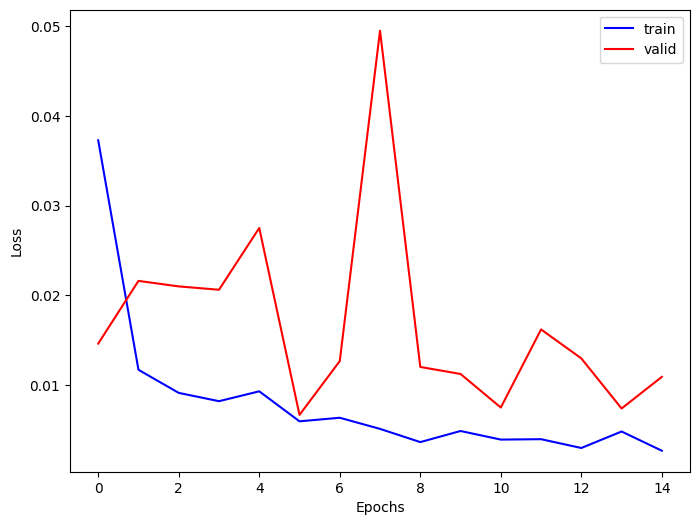

In [14]:
plt.figure(figsize=(8,6))
plt.plot(avg_train_losses,'b-',label='train')
plt.plot(avg_val_losses,'r-',label='valid')
# plt.ylim(0,200)
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('loss.jpg',dpi=150)
plt.show()

ROC-AUC (using recon error as score): 0.9557
PR-AUC (average precision): 0.7976


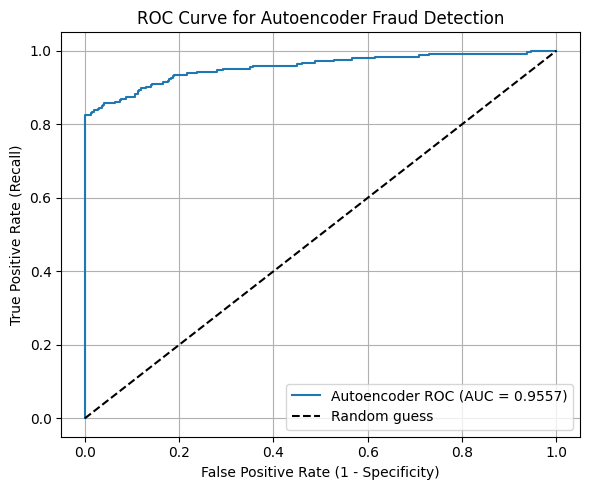


Threshold at train MSE quantile 0.980 -> thr=0.004475
              precision    recall  f1-score   support

         0.0     0.9990    0.9791    0.9890     42647
         1.0     0.1878    0.8374    0.3068       246

    accuracy                         0.9783     42893
   macro avg     0.5934    0.9083    0.6479     42893
weighted avg     0.9944    0.9783    0.9851     42893

Confusion matrix:
 [[41756   891]
 [   40   206]]

Threshold at train MSE quantile 0.990 -> thr=0.008447
              precision    recall  f1-score   support

         0.0     0.9990    0.9902    0.9946     42647
         1.0     0.3279    0.8252    0.4694       246

    accuracy                         0.9893     42893
   macro avg     0.6635    0.9077    0.7320     42893
weighted avg     0.9951    0.9893    0.9916     42893

Confusion matrix:
 [[42231   416]
 [   43   203]]

Threshold at train MSE quantile 0.995 -> thr=0.014863
              precision    recall  f1-score   support

         0.0     0.9990   

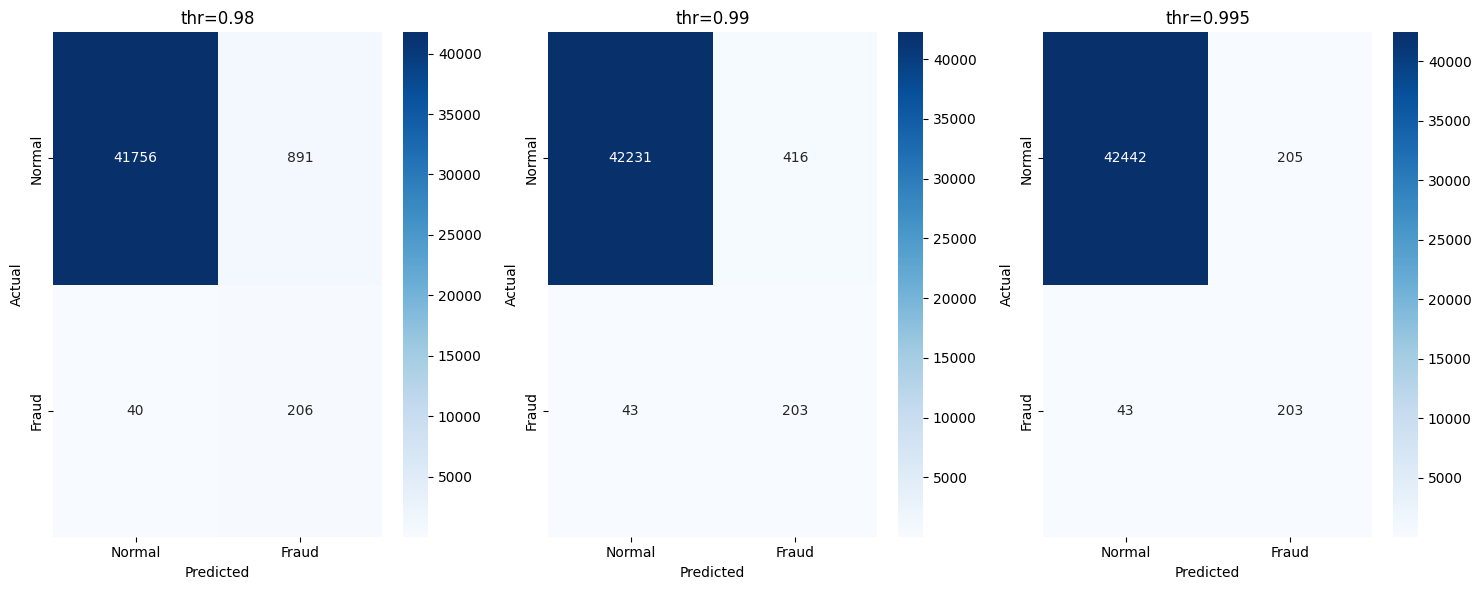

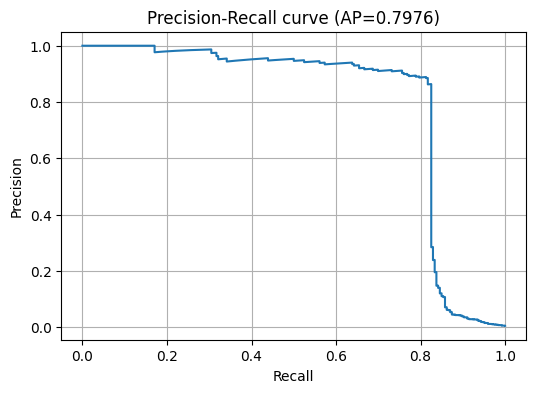

Best F1 on validation: 0.8499 at thr=0.164248


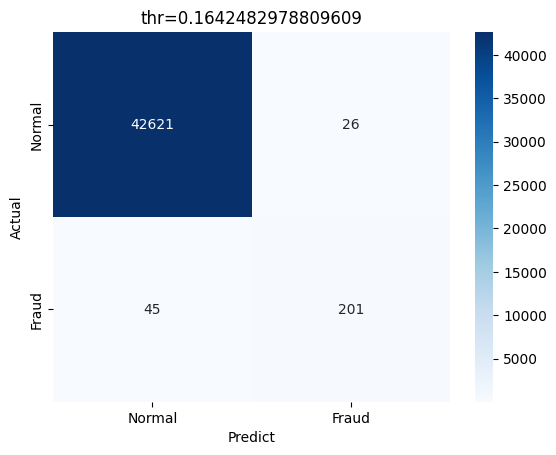

[[42621    26]
 [   45   201]]


In [15]:
THRESHOLDS = [0.98, 0.99, 0.995]

with torch.no_grad():
    X_val_t = torch.from_numpy(x_valid.astype(np.float32)).to(device)
    X_val_rec = model(X_val_t)
    val_mse = ((X_val_rec - X_val_t) ** 2).mean(dim=1).cpu().numpy()  # per-sample MSE

# 基本指標：ROC-AUC、PR-AUC
rocauc = roc_auc_score(y_valid, val_mse)
pr_auc = average_precision_score(y_valid, val_mse)
print(f"ROC-AUC (using recon error as score): {rocauc:.4f}")
print(f"PR-AUC (average precision): {pr_auc:.4f}")

from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# 計算 ROC 曲線與 AUC
fpr, tpr, thresholds = roc_curve(y_valid, val_mse)
roc_auc = roc_auc_score(y_valid, val_mse)

# 繪圖
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'Autoencoder ROC (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve for Autoencoder Fraud Detection')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig('ROC.jpg',dpi=150)
plt.show()


# 選 threshold：用 training 正常樣本的重建誤差分位數（常見做法）
# 計算 training 上的重建誤差分位數 (使用 train set)
with torch.no_grad():
    X_train_t = torch.from_numpy(x_normal_train.astype(np.float32)).to(device)
    X_train_rec = model(X_train_t)
    train_mse = ((X_train_rec - X_train_t) ** 2).mean(dim=1).cpu().numpy()

fig,ax=plt.subplots(ncols=3,nrows=1,figsize=(15,6))
for i,q in enumerate(THRESHOLDS):
    thr = np.quantile(train_mse, q)
    y_pred = (val_mse > thr).astype(int)
    print("\nThreshold at train MSE quantile {:.3f} -> thr={:.6f}".format(q, thr))
    print(classification_report(y_valid, y_pred, digits=4))
    cm = confusion_matrix(y_valid, y_pred)
    print("Confusion matrix:\n", cm)
    sns.heatmap(cm,annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'],ax=ax[i])
    ax[i].set_xlabel('Predicted')
    ax[i].set_ylabel('Actual')
    ax[i].set_title(f'thr={THRESHOLDS[i]}')
plt.tight_layout()
plt.show()

# 可畫 precision-recall curve（threshold-free）
precision, recall, pr_th = precision_recall_curve(y_valid, val_mse)
plt.figure(figsize=(6,4))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision-Recall curve (AP={pr_auc:.4f})")
plt.grid(True)
plt.savefig('PR.jpg',dpi=150)
plt.show()

# 若想用 F1 選 threshold（在 validation 上搜尋最佳 F1）
from sklearn.metrics import f1_score

best_f1 = 0
best_thr = None
for thr in np.linspace(val_mse.min(), val_mse.max(), 200):
    y_p = (val_mse > thr).astype(int)
    f1 = f1_score(y_valid, y_p)
    if f1 > best_f1:
        best_f1 = f1
        best_thr = thr

print(f"Best F1 on validation: {best_f1:.4f} at thr={best_thr:.6f}")
best_y_pred=(val_mse>best_thr).astype(int)
cm=confusion_matrix(y_valid,best_y_pred)
sns.heatmap(cm,annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'])
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.title(f'thr={best_thr}')
plt.show()
print(cm)

In [16]:
print('Train MSE range:', train_mse.min(), train_mse.max())
print('Val Normal mean MSE:', val_mse[y_valid==0].mean())
print('Val Fraud  mean MSE:', val_mse[y_valid==1].mean())

x_batch = torch.from_numpy(x_valid[:100].astype(np.float32)).to(device)
x_rec = model(x_batch).detach().cpu().numpy()

print("Input mean:", x_batch.cpu().numpy().mean(axis=0)[:5])
print("Recon mean:", x_rec.mean(axis=0)[:5])
print("Input std:", x_batch.cpu().numpy().std(axis=0)[:5])
print("Recon std:", x_rec.std(axis=0)[:5])


Train MSE range: 2.552566e-05 8.531386
Val Normal mean MSE: 0.0010696593
Val Fraud  mean MSE: 1.6541661
Input mean: [ 0.42966497 -0.1534487   0.00094374  0.170273   -0.14968449]
Recon mean: [ 0.40364227 -0.14365534 -0.00707472  0.16171421 -0.15829372]
Input std: [1.4435309 1.1497536 1.4754217 1.3877068 1.6956894]
Recon std: [1.4503715 1.1579946 1.4691533 1.3836657 1.6754551]


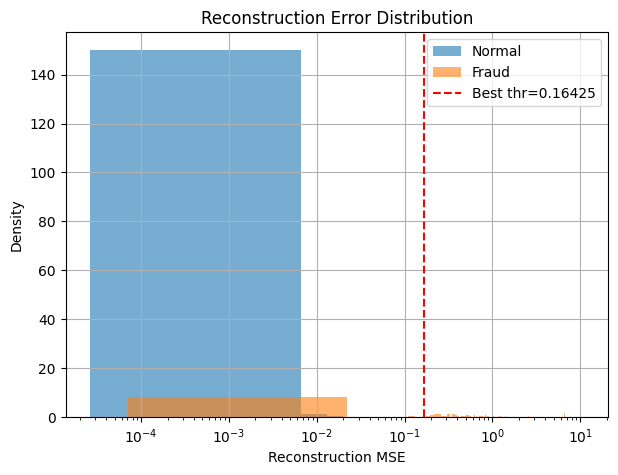

In [17]:
plt.figure(figsize=(7,5))
plt.hist(val_mse[y_valid==0], bins=500, alpha=0.6, label='Normal', density=True)
plt.hist(val_mse[y_valid==1], bins=500, alpha=0.6, label='Fraud', density=True)
plt.axvline(best_thr, color='r', linestyle='--', label=f'Best thr={best_thr:.5f}')
plt.xlabel('Reconstruction MSE')
plt.ylabel('Density')
plt.legend()
plt.title('Reconstruction Error Distribution')
plt.xscale('log')
plt.grid(True)
plt.show()
